In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder

### load data

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/'

In [3]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


In [4]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [5]:
C = 10
n_time_bins = 10

In [6]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]
spike_times = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])[:,0]

rand_idx = np.arange(n_trials)
train_idx = rand_idx[:int(.8*n_trials)]
test_idx = rand_idx[int(.8*n_trials):]

train_features = np.vstack([unsorted_trials[i][:,2:] for i in train_idx])
train_labels = choices[train_idx].argmax(1)
test_labels = choices[test_idx].argmax(1)

binning = np.arange(0, 1.5, step=(1.5 - 0)/n_time_bins)
n_trials = stim_on_times.shape[0]
spike_train = np.concatenate(unsorted_trials)[:,[0,2,3,4]]

trial_idx = []
time_idx = []
all_trials = []
for k in range(n_trials):
    mask = np.logical_and(spike_train[:,0] >= stim_on_times[k]-0.5,
                          spike_train[:,0] <= stim_on_times[k]+1
                         )
    trial = spike_train[mask,:]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    time_bins = np.digitize(trial[:,0], binning, right=False)-1
    for t in range(n_time_bins):
        time_bin = trial[time_bins == t, 1:]
        time_idx.append(np.ones_like(time_bin[:,0]) * t)
        trial_idx.append(np.ones_like(time_bin[:,0]) * k)
        all_trials.append(time_bin)
time_idx = np.concatenate(time_idx)
trial_idx = np.concatenate(trial_idx)
all_trials = np.concatenate(all_trials)

train_mask = np.sum([trial_idx == idx for idx in train_idx], axis=0).astype(bool)
train_trials = all_trials[train_mask]
train_time_idx = time_idx[train_mask]
train_trial_idx = trial_idx[train_mask]

test_mask = np.sum([trial_idx == idx for idx in test_idx], axis=0).astype(bool)
test_trials = all_trials[test_mask]
test_time_idx = time_idx[test_mask]
test_trial_idx = trial_idx[test_mask]

### encoder + MoG

In [164]:
C = 300

In [165]:
res_enc = np.load(save_path + f'cavi_results/res_enc_c{C}_t{n_time_bins}_count.npy', allow_pickle=True).item()
res_dec = np.load(save_path + f'cavi_results/res_dec_c{C}_t{n_time_bins}_count.npy', allow_pickle=True).item()

In [166]:
enc_lams = res_enc['lam'].numpy()
enc_means = res_enc['mu'].numpy()
enc_covs = res_enc['cov']
enc_covs = np.stack(enc_covs)

In [167]:
dec_nu_k = res_dec['nu'].numpy()
test_pred = (1. * (dec_nu_k > .5) ).astype(int)

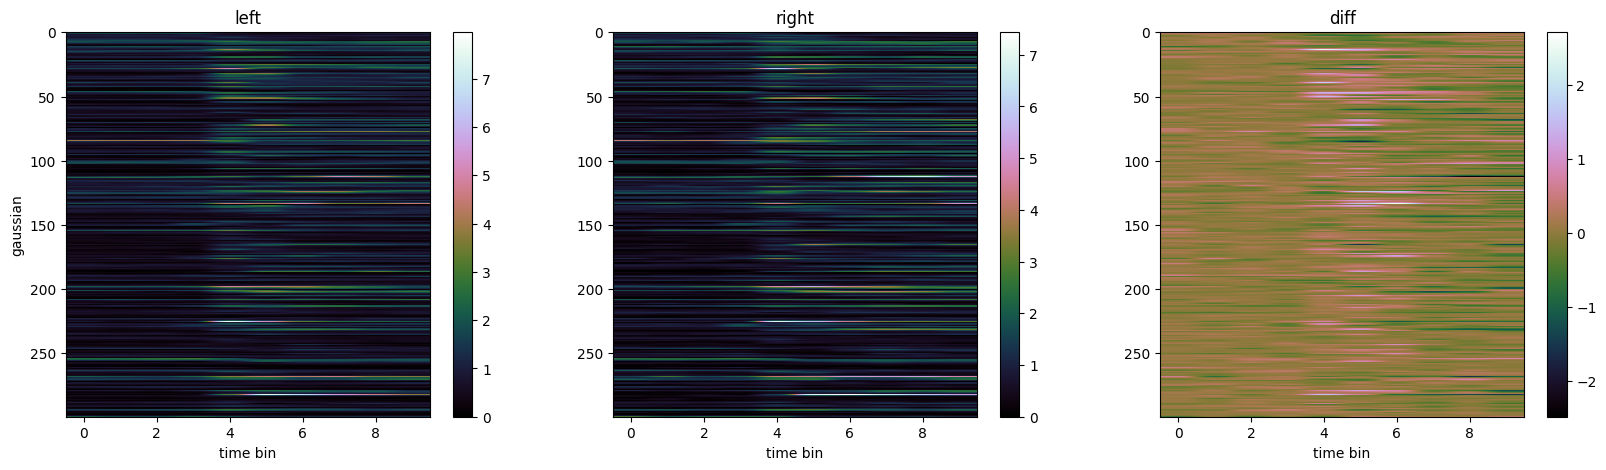

In [168]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(enc_lams[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title('left')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(enc_lams[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title('right')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(enc_lams[:,:,0] - enc_lams[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('diff')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

In [169]:
# compute time-varying pi_jt
enc_pis = enc_lams / enc_lams.sum(0)

In [170]:
enc_pis.shape

(300, 10, 2)

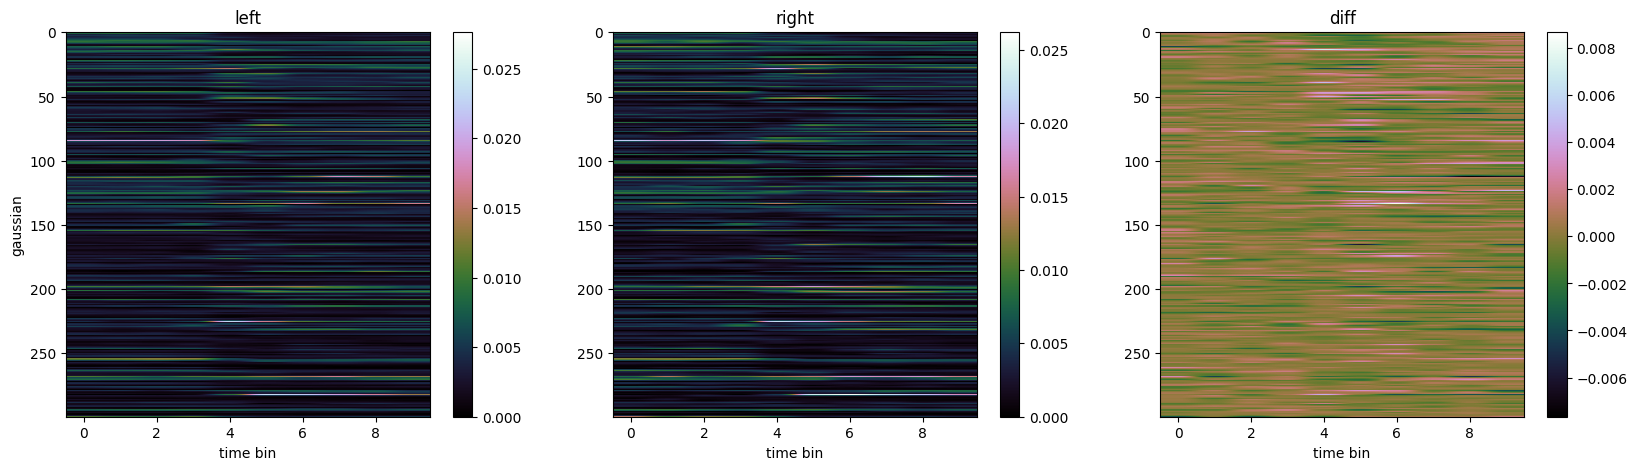

In [171]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(enc_pis[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title('left')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(enc_pis[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title('right')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(enc_pis[:,:,0] - enc_pis[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('diff')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

In [172]:
all_feat = []
for k in range(n_trials):
    mask = np.logical_and(spike_train[:,0] >= stim_on_times[k]-0.5,
                          spike_train[:,0] <= stim_on_times[k]+1
                         )
    trial = spike_train[mask,:]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    time_bins = np.digitize(trial[:,0], binning, right=False)-1
    time_bins_lst = []
    for t in range(n_time_bins):
        time_bin = trial[time_bins == t, 1:]
        time_bins_lst.append(time_bin)
    all_feat.append(time_bins_lst)
train_feat = [all_feat[k] for k in train_idx]
test_feat = [all_feat[k] for k in test_idx]

In [173]:
# compute weight matrix
K = len(train_idx)
T = 10
C = len(enc_means)
W_train = np.zeros((K, T, C))

for k in range(K):
    for t in range(T):
        modulated_gmm =  GaussianMixture(n_components=C, covariance_type='full')
        modulated_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(enc_covs))
        modulated_gmm.weights_ = enc_pis[:, t, train_labels[k]]
        modulated_gmm.means_ = enc_means
        modulated_gmm.covariances_ = enc_covs
        W_train[k,t,:] = modulated_gmm.predict_proba(train_feat[k][t]).sum(0)

In [174]:
W_train.shape

(212, 10, 300)

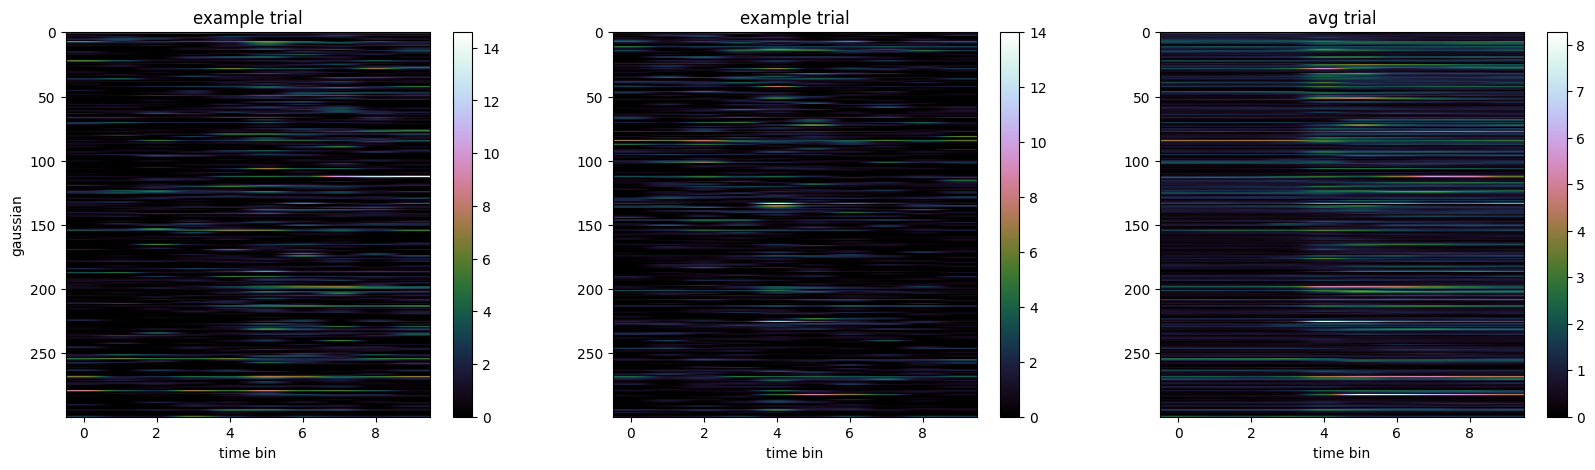

In [175]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(W_train[0].T, aspect='auto', cmap='cubehelix')
ax1.set_title('example trial')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(W_train[100].T, aspect='auto', cmap='cubehelix')
ax2.set_title('example trial')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(W_train.mean(0).T, aspect='auto', cmap='cubehelix')
ax3.set_title('avg trial')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

In [176]:
K = len(test_idx)
T = 10
C = len(enc_means)
W_test = np.zeros((K, T, C))

for k in range(K):
    for t in range(T):
        modulated_gmm =  GaussianMixture(n_components=C, covariance_type='full')
        modulated_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(enc_covs))
        modulated_gmm.weights_ = enc_pis[:, t, test_pred[k]]
        modulated_gmm.means_ = enc_means
        modulated_gmm.covariances_ = enc_covs
        W_test[k,t,:] = modulated_gmm.predict_proba(test_feat[k][t]).sum(0)

In [177]:
x_train = W_train.reshape(-1, W_train.shape[1]*W_train.shape[-1])
x_test = W_test.reshape(-1, W_test.shape[1]*W_test.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_labels)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_labels, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [178]:
print(acc)
print(auc)

0.9811320754716981
0.9980769230769231


### encoder + decoder

In [179]:
acc = accuracy_score(test_labels, test_pred)
auc = roc_auc_score(test_labels, dec_nu_k)

In [180]:
print(acc)
print(auc)

0.9811320754716981
1.0


### MoG only

In [181]:
init_gmm = np.load(save_path + f'cavi_results/init_gmm_c{C}_t{n_time_bins}.npy', allow_pickle=True).item()

In [182]:
init_weights = init_gmm['weights']
init_means = init_gmm['mu']
init_covs = init_gmm['cov']
init_covs = np.stack(init_covs)

In [183]:
loaded_gmm =  GaussianMixture(n_components=C, covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(init_covs))
loaded_gmm.weights_ = init_weights
loaded_gmm.means_ = init_means
loaded_gmm.covariances_ = enc_covs

In [184]:
spike_labels = []
spike_probs = []
spike_labels.extend(loaded_gmm.predict(all_trials))
spike_probs.extend(loaded_gmm.predict_proba(all_trials))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

In [185]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=n_time_bins
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 300, 10)


In [186]:
x_train = clusterless_neural_data[train_idx].reshape(-1, clusterless_neural_data.shape[1]*clusterless_neural_data.shape[-1])
x_test = clusterless_neural_data[test_idx].reshape(-1, clusterless_neural_data.shape[1]*clusterless_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_labels)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_labels, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [187]:
print(acc)
print(auc)

0.9622641509433962
0.9980769230769231


### sorted and good units

In [162]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
sorted neural data shape: (265, 514, 30)
good sorted neural data shape: (265, 83, 30)


In [163]:
x_train = sorted_neural_data[train_idx].reshape(-1, sorted_neural_data.shape[1]*sorted_neural_data.shape[-1])
x_test = sorted_neural_data[test_idx].reshape(-1, sorted_neural_data.shape[1]*sorted_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_labels)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_labels, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [164]:
print(acc)
print(auc)

0.8867924528301887
0.9865384615384616


In [165]:
x_train = good_sorted_neural_data[train_idx].reshape(-1, good_sorted_neural_data.shape[1]*good_sorted_neural_data.shape[-1])
x_test = good_sorted_neural_data[test_idx].reshape(-1, good_sorted_neural_data.shape[1]*good_sorted_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_labels)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_labels, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [166]:
print(acc)
print(auc)

0.9622641509433962
0.9769230769230769


### plotting

In [189]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [188]:
enc_dec_acc = [0.87, 0.96, 0.962, 1., 1., 0.981]
enc_dec_auc = [0.86, 0.97, 0.998, 1., 1., 1.]
enc_mog_acc = [0.74, 0.98, 0.962, 0.98, 0.98, 0.981]
enc_mog_auc = [0.79, 1, 0.996, 1., 1., 0.998]
mog_acc = [0.77, 0.94, 0.92, 0.96, 0.98, 0.962]
mog_auc = [0.82, 0.99, 0.99, 0.976, 0.996, 0.998]
sorted_all_acc = [0.8867924528301887]
sorted_all_auc = [0.9865384615384616]
good_units_acc = [0.9622641509433962]
good_units_auc = [0.9769230769230769]

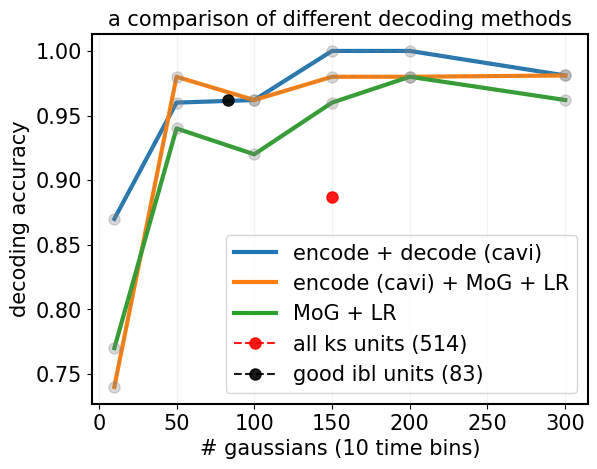

In [198]:
x = [10, 50, 100, 150, 200, 300]

plt.plot(x, enc_dec_acc, linewidth=3, label='encode + decode (cavi)')
plt.plot(x, enc_dec_acc, 'o--', markersize=8, color='grey', alpha=0.3)

plt.plot(x, enc_mog_acc, linewidth=3, label='encode (cavi) + MoG + LR')
plt.plot(x, enc_mog_acc, 'o--', markersize=8, color='grey', alpha=0.3)

plt.plot(x, mog_acc, linewidth=3, label='MoG + LR')
plt.plot(x, mog_acc, 'o--', markersize=8, color='grey', alpha=0.3)

plt.plot(150, sorted_all_acc, 'o--', color='red', markersize=8, alpha=0.9, label='all ks units (514)')
plt.plot(83, good_units_acc, 'o--', color='black', markersize=8, alpha=0.9, label='good ibl units (83)')

plt.grid(axis='x', color='0.95')
plt.xlabel('# gaussians (10 time bins)')
plt.ylabel('decoding accuracy')
plt.title('a comparison of different decoding methods')
plt.legend()
plt.savefig('perf_compare_acc.png', dpi=200)
plt.show()

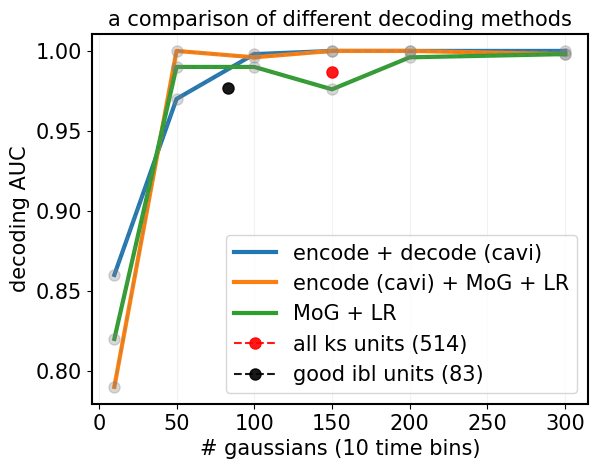

In [199]:
x = [10, 50, 100, 150, 200, 300]

plt.plot(x, enc_dec_auc, linewidth=3, label='encode + decode (cavi)')
plt.plot(x, enc_dec_auc, 'o--', markersize=8, color='grey', alpha=0.3)

plt.plot(x, enc_mog_auc, linewidth=3, label='encode (cavi) + MoG + LR')
plt.plot(x, enc_mog_auc, 'o--', markersize=8, color='grey', alpha=0.3)

plt.plot(x, mog_auc, linewidth=3, label='MoG + LR')
plt.plot(x, mog_auc, 'o--', markersize=8, color='grey', alpha=0.3)

plt.plot(150, sorted_all_auc, 'o--', color='red', markersize=8, alpha=0.9, label='all ks units (514)')
plt.plot(83, good_units_auc, 'o--', color='black', markersize=8, alpha=0.9, label='good ibl units (83)')

plt.grid(axis='x', color='0.95')
plt.xlabel('# gaussians (10 time bins)')
plt.ylabel('decoding AUC')
plt.title('a comparison of different decoding methods')
plt.legend()
plt.savefig('perf_compare_auc.png', dpi=200)
plt.show()